# Start Spark

In [1]:
#! pip install --upgrade pip
! pip install pyspark
! pip install delta
! pip install findspark
! pip install matplotlib
! pip install delta-spark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 1.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 7.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=2185da45c9261adf9880e788a5179bf14367763df82b78a06b894a449a82a861
  Stored in directory: /home/jovyan/.cache/pip/wheels/38/df/61/8c121f50c3cffd77f8178180dd232d90b3b99d1bd61fb6d6be
Successfully built pyspark
  Preparing metadata (setup.py) ... done
  Created wheel for delta: filename=delta-0.4.2-py3-none-any.whl size=2914 sha256=9741b19411f90bb90254b595f6bb3f2ff3ab2ea1ffe9af706a53c0bb0b2cab6b
  Stored in directory: /home/jovyan/.cache/pip/wheels/d7/a2/b5/3ce87a230774a38399b99ed3b0db048e3c3d8f1b76ff9feb8d
Successfully built delta


In [2]:
import pyspark
from delta import *
import os
import requests
import json
from time import sleep

In [3]:
builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")\
    .config("hive.server2.thrift.port", 10000)\
    .config("spark.sql.hive.thriftServer.singleSession", True)

spark = configure_spark_with_delta_pip(builder).getOrCreate()

In [4]:
table = "initiallog_data"

In [11]:
from pyspark.sql.functions import *
# File location and type
file = "example"
file_location = f"{file}.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
.option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df = df.withColumn("Date", to_date(df["Date"], "MM/dd/yyyy"))

In [12]:
display(df)

DataFrame[Date: date, Category: string, Portfolio(if applicable): string, Security: string, Fund Name: string, Action: string, Transaction Type: string, Quantity: double, Price: string, Amount: string]

In [13]:
df.createOrReplaceTempView(table)

In [14]:
columns = """
date, Category,
`Portfolio(if applicable)` as Portfolio,
Security,`Fund Name` as Name,
Action,`Transaction Type` as Transaction, 
replace(replace(Quantity, '(','-'),')','') as Quantity,
replace(Price,'$','') as Price,
replace(replace(replace(Amount, '(','-'),')',''),'$','') as Amount"""

In [15]:
df1 = spark.sql("select "+columns+" from initiallog_data order by date asc")

In [16]:
df1.show()

+----------+--------------------+--------------------+--------+--------------------+------+--------------------+--------+------+------+
|      date|            Category|           Portfolio|Security|                Name|Action|         Transaction|Quantity| Price|Amount|
+----------+--------------------+--------------------+--------+--------------------+------+--------------------+--------+------+------+
|2018-11-08|Employer matching...|Aggressive Portfolio|   VINAX|Vanguard Industri...|   Buy|Safe Harbor Match...|   0.099|70.55 | 7.00 |
|2018-11-08|Employee pre-tax ...|Aggressive Portfolio|   VITAX|Vanguard Informat...|   Buy|Pre-tax contribut...|    0.18|97.34 |17.50 |
|2018-11-08|Employee pre-tax ...|Aggressive Portfolio|   VTSAX|Vanguard Total St...|   Buy|Pre-tax contribut...|   1.377|69.89 |96.25 |
|2018-11-08|Employee pre-tax ...|Aggressive Portfolio|   VINAX|Vanguard Industri...|   Buy|Pre-tax contribut...|   0.124|70.55 | 8.75 |
|2018-11-08|Employee pre-tax ...|Aggressive Port

In [17]:
spark.sql("select min(date), max(date) from initiallog_data").show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2018-11-08|2018-12-24|
+----------+----------+



In [19]:
df1.write.format("delta").mode("overwrite").saveAsTable("`portfolio_delta`")

# after import and some data cleaning

In [21]:
df2 = spark.read.format('delta').load("spark-warehouse/portfolio_delta")

In [22]:
#display(df2)
df2.show()

+----------+--------------------+--------------------+--------+--------------------+------+--------------------+--------+------+------+
|      date|            Category|           Portfolio|Security|                Name|Action|         Transaction|Quantity| Price|Amount|
+----------+--------------------+--------------------+--------+--------------------+------+--------------------+--------+------+------+
|2018-11-08|Employee pre-tax ...|Aggressive Portfolio|   VITAX|Vanguard Informat...|   Buy|Pre-tax contribut...|    0.18|97.34 |17.50 |
|2018-11-08|Employee pre-tax ...|Aggressive Portfolio|   VTSAX|Vanguard Total St...|   Buy|Pre-tax contribut...|   1.377|69.89 |96.25 |
|2018-11-08|Employee pre-tax ...|Aggressive Portfolio|   VINAX|Vanguard Industri...|   Buy|Pre-tax contribut...|   0.124|70.55 | 8.75 |
|2018-11-08|Employee pre-tax ...|Aggressive Portfolio|   DFCEX|DFA Emerging Mark...|   Buy|Pre-tax contribut...|   0.267|19.63 | 5.25 |
|2018-11-08|Employee pre-tax ...|Aggressive Port

In [23]:
df2.createOrReplaceTempView(table)

# High Level Stats

In [26]:
spark.sql("""
        select 
            Security,
            float(sum(`Amount`)) Amount
        from initiallog_data
        group by Security        
""")\
.show()

+--------+------+
|Security|Amount|
+--------+------+
|   VINAX| 63.23|
|   RERGX| 90.73|
|   VSGDX|252.21|
|   VITAX|126.34|
|   DFCEX| 37.98|
|   VTSAX|696.57|
+--------+------+



# By Year amounts

In [27]:
spark.sql("""
        select 
            year(`Date`),
            float(sum(`Amount`))
        from initiallog_data
        group by year(`Date`) 
        order by year(`Date`) asc
""")\
.show()

+----------+-----------+
|year(Date)|sum(Amount)|
+----------+-----------+
|      2018|    1267.06|
+----------+-----------+



# My Contribution Amounts By Year

In [28]:
spark.sql("""
        select 
            year(`Date`),
            float(sum(`Amount`))
        from initiallog_data 
        where
        category in ('EE Roth Deferral', 'Employee pre-tax contributions')
        and
        Action <> 'REINVDIV'
        group by year(`Date`) 
        order by year(`Date`) asc
""")\
.show()

+----------+-----------+
|year(Date)|sum(Amount)|
+----------+-----------+
|      2018|     699.96|
+----------+-----------+



# All Other Contributions Amounts By Year

In [30]:
spark.sql("""
        select 
            year(`Date`),
            float(sum(`Amount`))
        from initiallog_data 
        where
        category not in ('EE Roth Deferral', 'Employee pre-tax contributions')
        group by year(`Date`) 
        order by year(`Date`) asc
""")\
.show()

+----------+-----------+
|year(Date)|sum(Amount)|
+----------+-----------+
|      2018|     563.12|
+----------+-----------+



# Fees allocated By Year

In [33]:
spark.sql("""
        select 
            year(`Date`),
            sum(`Amount`) as Fee 
        from initiallog_data 
        where 
        
        transaction like 'Fee of%to Aggressive Portfolio - %' 
        group by year(`Date`)         
""")\
.show()

+----------+--------------------+
|year(Date)|                 Fee|
+----------+--------------------+
|      2018|-0.07999999999999999|
+----------+--------------------+



# Visual Percentage of Contributions

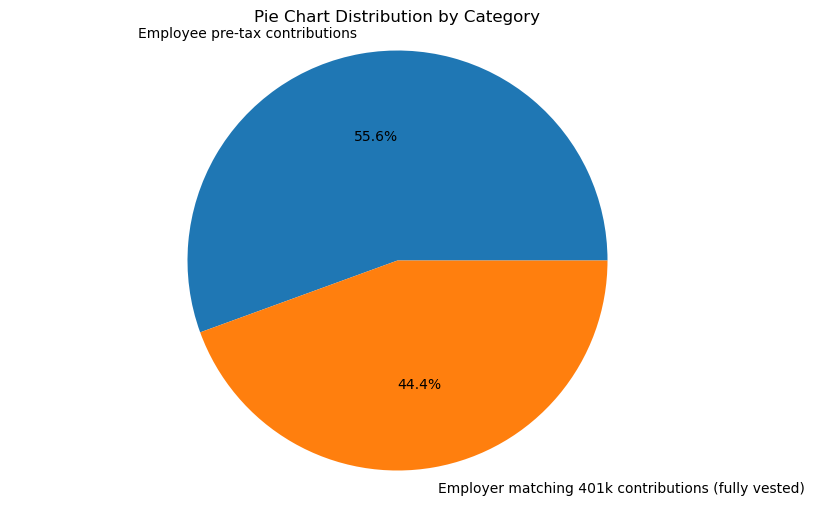

In [34]:
# provide a pie chart based on the category and the amount of df2 
import matplotlib.pyplot as plt

# Convert the 'Amount' column from String type to Float type
df3 = df2.withColumn("Amount", df2["Amount"].cast("Float"))

# Group by 'Category' and sum 'Amount', convert to pandas for plotting   
df_pandas = df3.groupBy("Category").sum("Amount").toPandas()

# Plotting
plt.figure(figsize=(10,6))
plt.pie(df_pandas['sum(Amount)'], labels=df_pandas['Category'], autopct='%1.1f%%')
plt.axis('equal') # Ensure the pie chart is circular
plt.title('Pie Chart Distribution by Category')
plt.show()

In [35]:
category = spark.createDataFrame(df_pandas.sort_values(by="sum(Amount)", ascending=False))
category[category["sum(Amount)"] > 1].show(truncate=False)

+---------------------------------------------------+-----------------+
|Category                                           |sum(Amount)      |
+---------------------------------------------------+-----------------+
|Employee pre-tax contributions                     |703.9399999380112|
|Employer matching 401k contributions (fully vested)|563.1200000271201|
+---------------------------------------------------+-----------------+



In [36]:
spark.sql("""
        select * from initiallog_data 
        where transaction like '%Divid%'
""")\
.show(truncate=False)
#where security = 'VITSX'

+----------+---------------------------------------------------+--------------------+--------+----------------------------------------+--------+-------------------------------------------------------------------------------------------+--------+------+------+
|date      |Category                                           |Portfolio           |Security|Name                                    |Action  |Transaction                                                                                |Quantity|Price |Amount|
+----------+---------------------------------------------------+--------------------+--------+----------------------------------------+--------+-------------------------------------------------------------------------------------------+--------+------+------+
|2018-11-30|Employer matching 401k contributions (fully vested)|Aggressive Portfolio|VSGDX   |Vanguard Short-Term Federal Admiral     |REINVDIV|Dividend of $0.10 to Aggressive Portfolio - VSGDX Vanguard Short-Term Federa

-- %% sql
-- SELECT 
-- CASE 
-- WHEN 1 > 0 THEN 1 
-- WHEN 2 > 0 THEN 2.0 
-- ELSE 1.2 
-- END;

# Active Funds and their Last Buy Date

In [37]:
ActiveFunds = \
spark.sql("""
    SELECT
        security,
        max(date) as LastBuy
    from initiallog_data
    group by security
    order by lastbuy desc
""")

In [38]:
ActiveFunds.show()

+--------+----------+
|security|   LastBuy|
+--------+----------+
|   VTSAX|2018-12-24|
|   RERGX|2018-12-21|
|   VINAX|2018-12-20|
|   VSGDX|2018-12-20|
|   VITAX|2018-12-20|
|   DFCEX|2018-12-20|
+--------+----------+



In [39]:
ActiveFunds.createOrReplaceTempView("ActiveFunds")

In [43]:
spark.sql("select '2018-12-31' `Date`").show()

+----------+
|      Date|
+----------+
|2018-12-31|
+----------+



# Active Funds and Last Buy Date was less than 1 month ago

In [45]:
spark.sql(f"""
        SELECT
            sd.security,
            Name
        from initiallog_data sd
        inner join ActiveFunds af on sd.security = af.security
        group by sd.security, Name        
""").show(truncate=False)

+--------+----------------------------------------+
|security|Name                                    |
+--------+----------------------------------------+
|RERGX   |American Funds EuroPacifc Gr R6         |
|VITAX   |Vanguard Information Technology Index Ad|
|VINAX   |Vanguard Industrial Index Admiral       |
|VSGDX   |Vanguard Short-Term Federal Admiral     |
|VTSAX   |Vanguard Total Stock Market Index Admira|
|DFCEX   |DFA Emerging Markets Core Equity        |
+--------+----------------------------------------+



In [46]:
securities = spark.sql(f"""
        SELECT
            name,
            security,            
            sum(quantity), 
            sum(amount) 
        from initiallog_data sd
        group by security,name
        order by sum(Amount) desc
""")

In [47]:
securities.show()

+--------------------+--------+------------------+------------------+
|                name|security|     sum(quantity)|       sum(amount)|
+--------------------+--------+------------------+------------------+
|Vanguard Total St...|   VTSAX|10.557999999999998|            696.57|
|Vanguard Short-Te...|   VSGDX|            24.063|252.20999999999998|
|Vanguard Informat...|   VITAX|1.3989999999999998|            126.34|
|American Funds Eu...|   RERGX|             1.919| 90.72999999999999|
|Vanguard Industri...|   VINAX|             0.955|63.230000000000004|
|DFA Emerging Mark...|   DFCEX|1.9539999999999997|             37.98|
+--------------------+--------+------------------+------------------+



In [73]:
investments = securities[["security"]].toPandas().to_dict()

In [85]:
[item for _, item in investments["security"].items()]

['VTSAX', 'VSGDX', 'VITAX', 'RERGX', 'VINAX', 'DFCEX']

# Establish a TwelveData API Key

In [ ]:
closedData = {}

for i,symbol in enumerate(investments.keys()):
    url = f"""
    https://api.twelvedata.com/time_series?apikey={os.environ["twelvedata"]}&interval=1min&symbol={symbol}&format=JSON
    """
    if i > 8:
        sleep(2)
    r = requests.get(url,)
    
    if r.status_code <= 201 :
        data = r.json().get("values")        
        if data is not None:
            item = data[0]
            closedData[symbol] = item            
        else:            
            closedData[symbol] = "no data"
    else:
        print(r.status_code)
    sleep(5)
    

print(closedData)

# Create Pricing View

In [88]:
spark.sql(f"""
        create or replace temporary view Pricing as
        select 
            security, 
            date,
            first(price) as Price
        from initiallog_data sd
        group by security, date
        order by security, date desc
""")

DataFrame[]

In [89]:
data = spark.sql("select security, to_date(`Date`) date, cast(`price` as float) as Price from Pricing")

In [90]:
data.head()

Row(security='DFCEX', date=datetime.date(2018, 12, 20), Price=19.06999969482422)

# Security and Pricing by Date

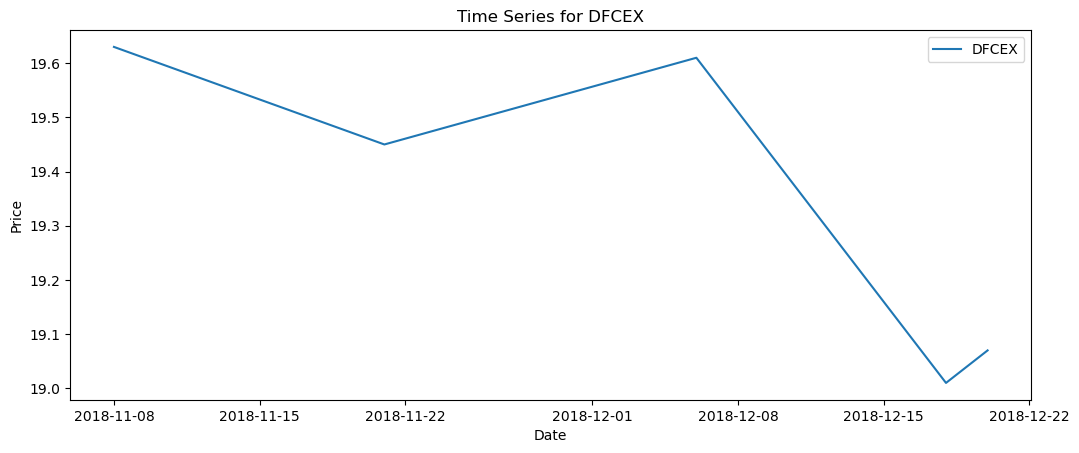

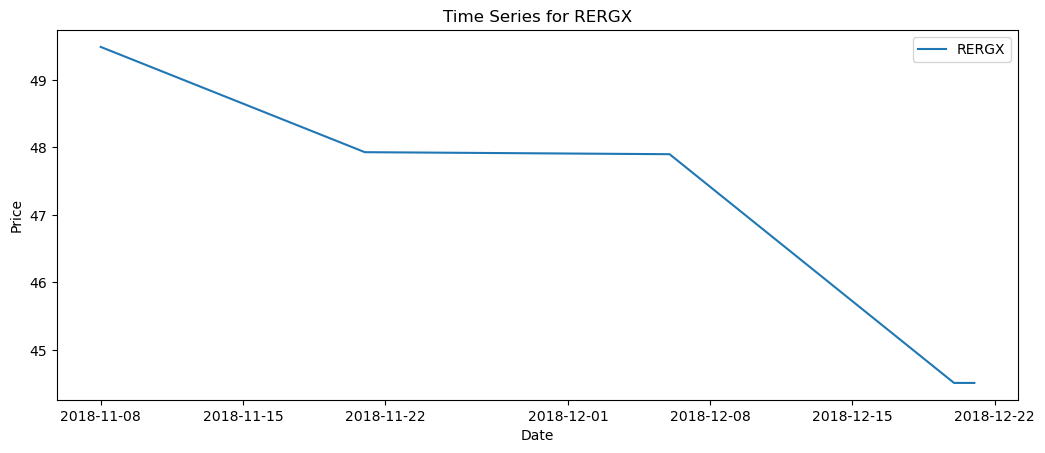

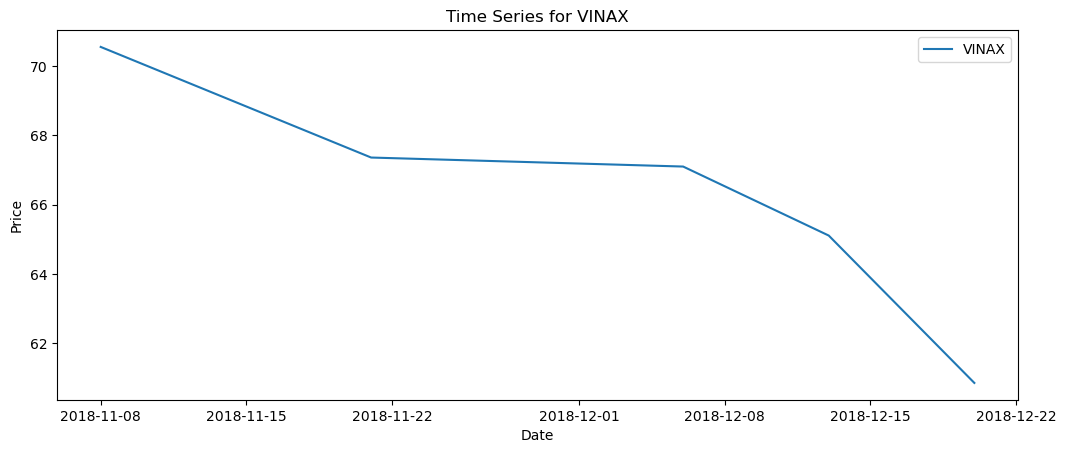

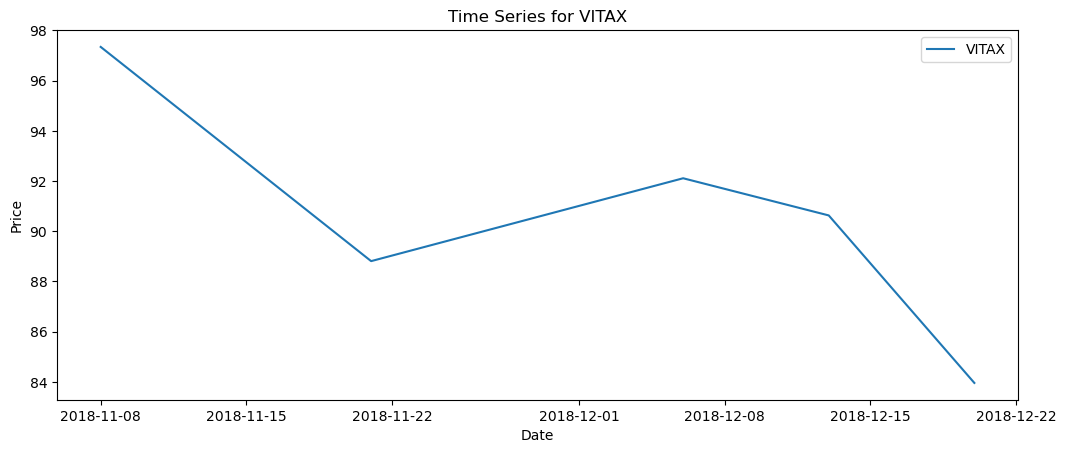

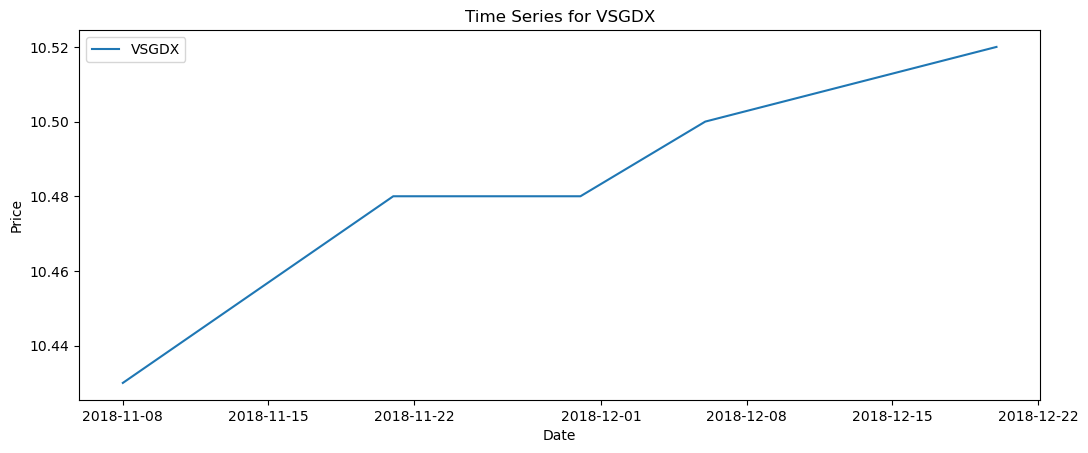

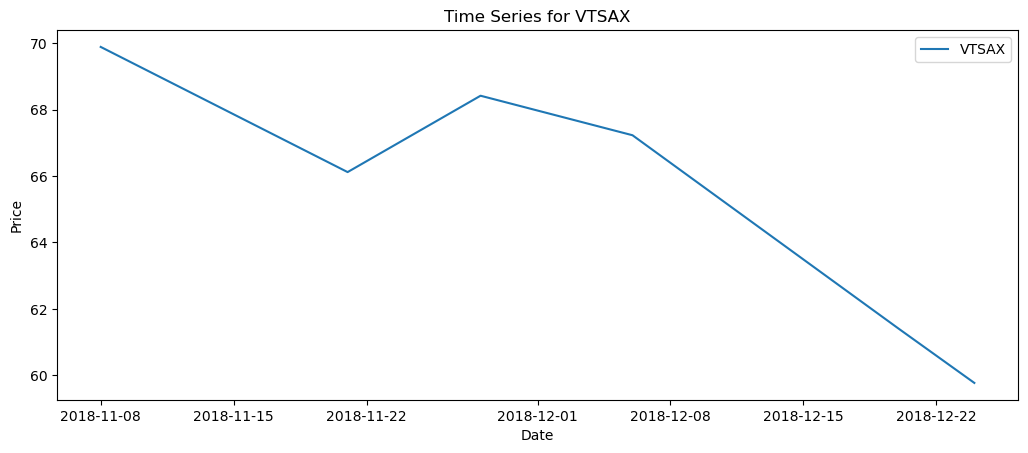

In [91]:
import matplotlib.pyplot as plt
from datetime import datetime

# Convert the spark dataframe to a pandas dataframe
pdf = data.toPandas()

now = datetime.now()
today = now.strftime("%m-%d-%Y")
# Plot the time series for each security using matplotlib on a different figure
for security in pdf["security"].unique():
  # Create a new figure
  fig = plt.figure(figsize=(12.4,4.8))
  # Plot the data for the current security
  plt.plot(pdf[pdf["security"] == security]["date"], pdf[pdf["security"] == security]["Price"], label=security)
  # Set the labels and title
  plt.xlabel("Date")
  plt.ylabel("Price")
  plt.title(f"Time Series for {security}")
  # Add a legend
  plt.legend()
  # Show the figure
  plt.savefig(f'{security}-{today}.svg', format='svg')
  plt.show()
  plt.close(fig)

# Personal Contributions (Category is EE Roth Deferral / Employee pre-tax contributions )

In [93]:
spark.sql("""
        select 
                distinct year(to_date(`date`)) as Year,                
                category,
                sum(amount) 
        from initiallog_data 
        where
        category in ('EE Roth Deferral', 'Employee pre-tax contributions') 
        group by year(to_date(`date`)), category
        order by Year asc
""")\
.show(truncate=False,n=50)

+----+------------------------------+-----------+
|Year|category                      |sum(amount)|
+----+------------------------------+-----------+
|2018|Employee pre-tax contributions|703.94     |
+----+------------------------------+-----------+

